<a href="https://colab.research.google.com/github/saifulislamsarfaraz/Statistics-for-Data-Science/blob/main/Brain_tumer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders
!pip install monai
!pip install torchsummary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install --upgrade pytorch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-z68n2w8j/pytorch_d464f723ee71405cb615fa6bd44d4dbe/setup.py'"'"'; __file__='"'"'/tmp/pip-install-z68n2w8j/pytorch_d464f723ee71405cb615fa6bd44d4dbe/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-8xcjtsqr/install-record.txt --single-version-externally-managed --compile --install-headers /usr/

In [5]:
import os
import PIL
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from torchsummary import summary
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
from torchvision import transforms,datasets,models
import splitfolders
from monai.networks.nets import DenseNet201,DenseNet121
from sklearn.metrics import accuracy_score,classification_report

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/Brain'

##  Data Preparing

In [7]:
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/Brain/Training',ratio=(0.8,0.2))

Copying files: 2878 files [00:42, 67.22 files/s] 


In [8]:
test_path = os.path.join(path,'Testing')
train_path = './output/train'
val_path = './output/val'

In [9]:
data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}
data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

In [10]:
for phase in ['train','val','test']:
    if phase == 'train':
        data_dir = train_path
    elif phase == 'val':
        data_dir = val_path
    else:
        data_dir = test_path
    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 
    image_files = [
        [
            os.path.join(data_dir, class_names[i], x)
            for x in os.listdir(os.path.join(data_dir, class_names[i]))
        ]
        for i in range(num_class)
    ]
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    print(f"{phase} information")
    print(f"Image dimensions: {image_width} x {image_height}")
    print(f"Label names: {class_names}")
    print(f"Label counts: {num_each}")
    print(f"Total image count: {num_total}")
    print('--'*8)

train information
Image dimensions: 512 x 512
Label names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label counts: [660, 657, 322, 661]
Total image count: 2300
----------------
val information
Image dimensions: 512 x 512
Label names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label counts: [166, 165, 81, 166]
Total image count: 578
----------------
test information
Image dimensions: 386 x 406
Label names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label counts: [100, 115, 105, 74]
Total image count: 394
----------------


The original training set is divided into training set and verification set proportionally

## Visualize

([<matplotlib.patches.Wedge at 0x7f379450c690>,
 [Text(0.8636160276453844, 0.6812982876787573, 'glioma_tumor'),
  Text(0.46291224867720315, -0.9978538219722444, 'meningioma_tumor'),
  Text(-1.0766857864938464, -0.2252725397427029, 'no_tumor'),
  Text(-0.46835731577295536, 0.995309712984834, 'pituitary_tumor')],
 [Text(0.47106328780657325, 0.37161724782477673, '28.7%'),
  Text(0.25249759018756535, -0.5442839028939515, '28.7%'),
  Text(-0.5872831562693707, -0.122875930768747, '28.6%'),
  Text(-0.25546762678524837, 0.5428962070826366, '14.0%')])

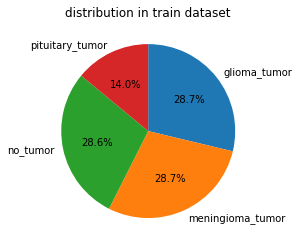

In [11]:
df = pd.DataFrame({'path': data_dicts['train'],'label': data_labels['train']})
sorted_counts  = df.value_counts('label')
plt.title('distribution in train dataset')
plt.pie(sorted_counts, labels = class_names,startangle = 90,counterclock = False,autopct="%.1f%%")

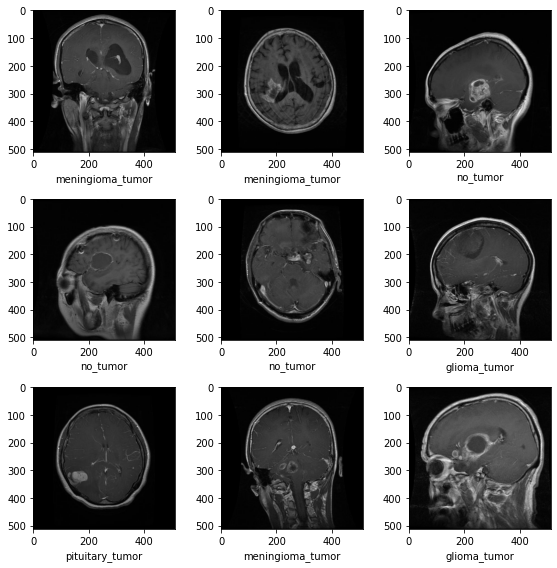

In [13]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(data_dicts['train'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Train Preparing

In [14]:
#define transforms
data_transforms = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(-3,3)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                    ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                   ]),
        "test":transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
}

In [15]:
data_sets = {
    "train":datasets.ImageFolder(train_path,transform = data_transforms['train']),
    "val":datasets.ImageFolder(val_path,transform = data_transforms['val']),
    "test":datasets.ImageFolder(test_path,transform = data_transforms['test']),
}
num_train = len(data_sets["train"])
num_val = len(data_sets["val"])
datasizes = {'train':num_train,'val':num_val}

In [16]:
batch_size = 32
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 2 dataloader workers every process


Define dataloader

In [17]:
dataloaders = {
    "train":torch.utils.data.DataLoader(data_sets['train'],batch_size=batch_size,shuffle=True,num_workers=nw),
    "val":torch.utils.data.DataLoader(data_sets['val'],batch_size=batch_size,shuffle=False,num_workers=nw),
    "test":torch.utils.data.DataLoader(data_sets['test'],batch_size=batch_size,shuffle=False,num_workers=nw)
}

In [18]:

for i,data in enumerate(dataloaders['train']):
    images,labels = data
    print(images.shape)
    break

torch.Size([32, 3, 256, 256])


choose a pretrained model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.mobilenet_v3_large(pretrained=True)
num_features=model.classifier[0].in_features
model.classifier=nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4, bias=True)
  )
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Setting Lossfunction Optimizer and HyperParameters 

In [20]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
num_epochs = 30
best_acc = 0.0
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [22]:
for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            train_bar = tqdm(dataloaders[phase], file=sys.stdout)
            
            #batch
            for step,data in enumerate(train_bar):
                optimizer.zero_grad()
                X,y_true = data
                with torch.set_grad_enabled(phase == 'train'):
                    y_predict = model(X.to(device))
                    _, pred_labels = torch.max(y_predict, 1)
                    # _, pred_labels = torch.max(y_predict.item(), 1)
                    loss = loss_function(y_predict, y_true.to(device))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * X.size(0)#batch_size
                running_corrects += torch.sum(pred_labels == y_true.data.to(device))
                # running_corrects += torch.sum(pred_labels == y_true.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / datasizes[phase]
            epoch_acc = running_corrects.double() / datasizes[phase]
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            elif phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
            print('Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),'best_checkpoint.model')
                
print('Best val Acc: {:4f}'.format(best_acc))      

Epoch 1/30
----------
100%|██████████| 72/72 [07:25<00:00,  6.18s/it]
train阶段 Loss: 0.7330 Acc: 0.7343
100%|██████████| 19/19 [00:09<00:00,  1.91it/s]
val阶段 Loss: 4.2609 Acc: 0.5035
Epoch 2/30
----------
100%|██████████| 72/72 [11:32<00:00,  9.62s/it]
train阶段 Loss: 0.4425 Acc: 0.8365
100%|██████████| 19/19 [00:09<00:00,  1.92it/s]
val阶段 Loss: 1.2856 Acc: 0.7734
Epoch 3/30
----------
100%|██████████| 72/72 [12:06<00:00, 10.10s/it]
train阶段 Loss: 0.4244 Acc: 0.8509
100%|██████████| 19/19 [00:09<00:00,  2.07it/s]
val阶段 Loss: 1.3722 Acc: 0.7197
Epoch 4/30
----------
100%|██████████| 72/72 [13:48<00:00, 11.50s/it]
train阶段 Loss: 0.3350 Acc: 0.8874
100%|██████████| 19/19 [00:12<00:00,  1.54it/s]
val阶段 Loss: 0.4170 Acc: 0.8616
Epoch 5/30
----------
100%|██████████| 72/72 [11:18<00:00,  9.42s/it]
train阶段 Loss: 0.3424 Acc: 0.8757
100%|██████████| 19/19 [00:09<00:00,  2.05it/s]
val阶段 Loss: 0.4965 Acc: 0.8633
Epoch 6/30
----------
100%|██████████| 72/72 [08:04<00:00,  6.74s/it]
train阶段 Loss: 0.2714

In [23]:
acc_dict = {'train':torch.tensor(train_acc_list, device='cpu') .tolist(),'val':torch.tensor(val_acc_list, device='cpu') .tolist()}
loss_dict = {'train':torch.tensor(train_loss_list, device='cpu') .tolist(),'val':torch.tensor(val_loss_list, device='cpu').tolist()}

In [24]:
max_accvalue = max(acc_dict['val'])
max_accidx = acc_dict['val'].index(max_accvalue)+1
min_lossvalue = min(loss_dict['val'])
min_lossidx = loss_dict['val'].index(min_lossvalue)+1

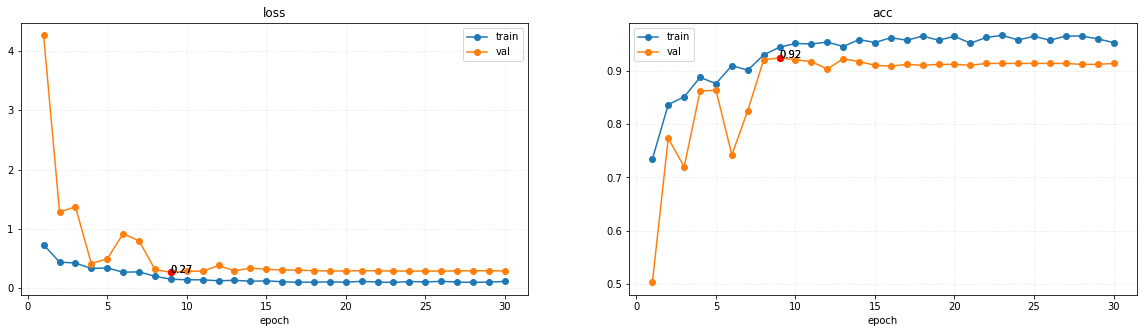

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.4,linestyle=':')
x = [i + 1 for i in range(num_epochs)]
for phase in ['train','val']:
    plt.plot(x,loss_dict[phase],'-o',label=phase)
    plt.legend()
    plt.plot(min_lossidx,min_lossvalue,'-ro')
    plt.annotate(round(min_lossvalue,2), xy=(min_lossidx, min_lossvalue))
plt.subplot(1,2,2)
plt.title('acc')
plt.xlabel('epoch')
plt.grid(alpha=0.4,linestyle=':')
for phase in ['train','val']:
    plt.plot(x,acc_dict[phase],'-o',label=phase)
    plt.legend()
    plt.plot(max_accidx,max_accvalue,'-ro')
    # plt.annotate(round(max_value,2), xy=(max_idx, max_value),xytext=(max_idx, max_idx))
    plt.annotate(round(max_accvalue,2), xy=(max_accidx, max_accvalue))

##  Evaluation

In [26]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual,y_pred,target_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
        print(f"{acc}")


In [27]:
test(model,dataloaders['test'])

[0 1 2 3]
                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.27      0.40       100
meningioma_tumor       0.71      0.83      0.77       115
        no_tumor       0.60      0.96      0.74       105
 pituitary_tumor       0.78      0.64      0.70        74

        accuracy                           0.69       394
       macro avg       0.72      0.67      0.65       394
    weighted avg       0.72      0.69      0.66       394



In [28]:
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         Hardswish-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]             144
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             256
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]           1,024
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13           [-1, 64, 64, 64]             576
      BatchNorm2d-14           [-1, 64,